In [1]:
import sys
import os

sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import (
    RandomIntervalSDOMLDataset,
    RandomIntervalSDOMLDataModule,
)
from sdofm.datasets.BrightSpotsSDOML import (
    BrightSpotsSDOMLDataset,
    BrightSpotsSDOMLDataModule,
)
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch
from sdofm.models import unet

In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [62]:
data_module = BrightSpotsSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=10,
    num_workers=3,
    blosc_cache="/home/rlx/blosc_cache",
    start_date="2012-01-01",
    end_date="2014-12-31",
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [63]:
model = torch.load("unetmodel_12ch_1classes_bilinear_sizefactor4.ckpt")

In [70]:
dl = data_module.train_dataloader()
for batch in pbar(dl, max_value=len(dl)):
    break

  0% (0 of 9007) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

In [71]:
image_stack = batch["image_stack"].cuda()
preds = model(image_stack)
x = model.forward_encode(image_stack)
embs = model.forward_to_embeddings(x)

In [72]:
brigh_spots = batch["bright_spots"]

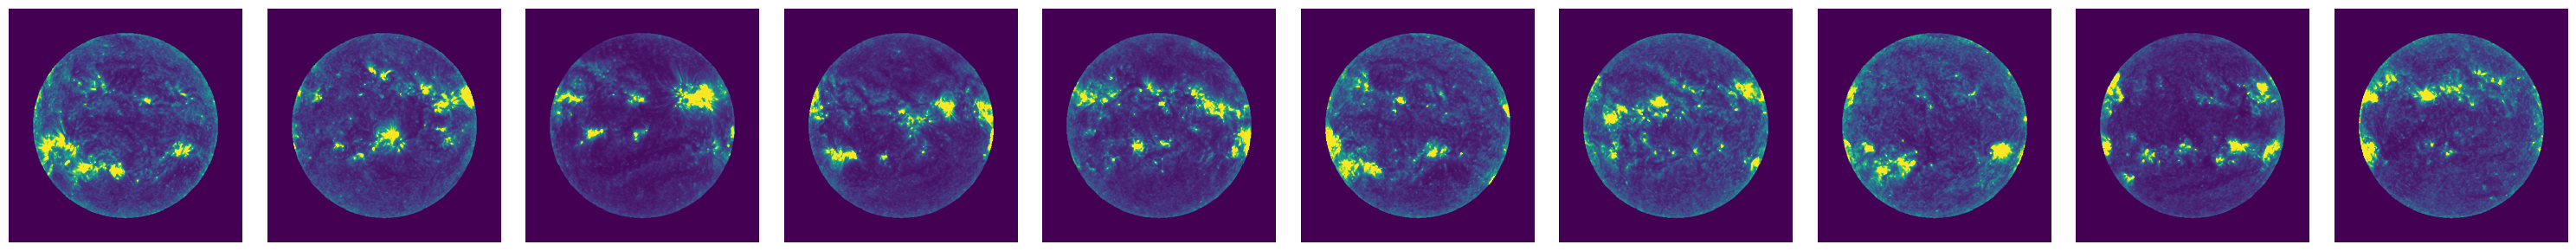

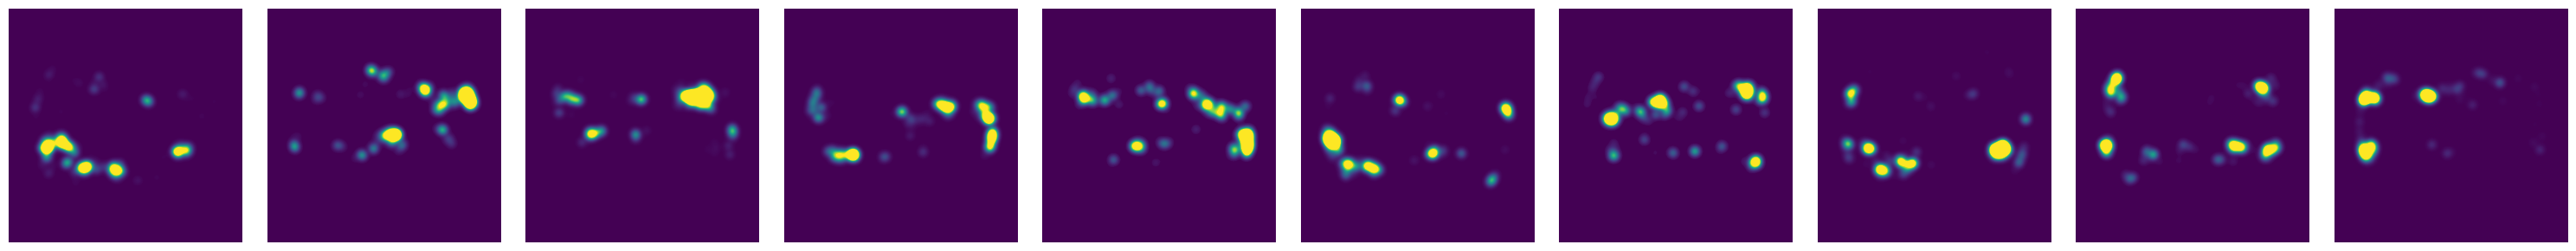

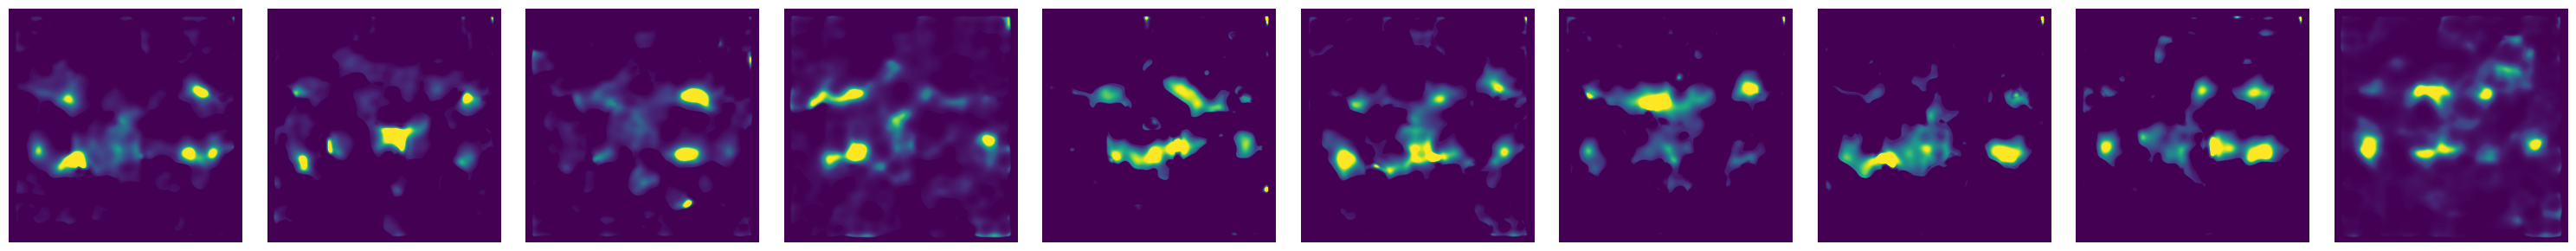

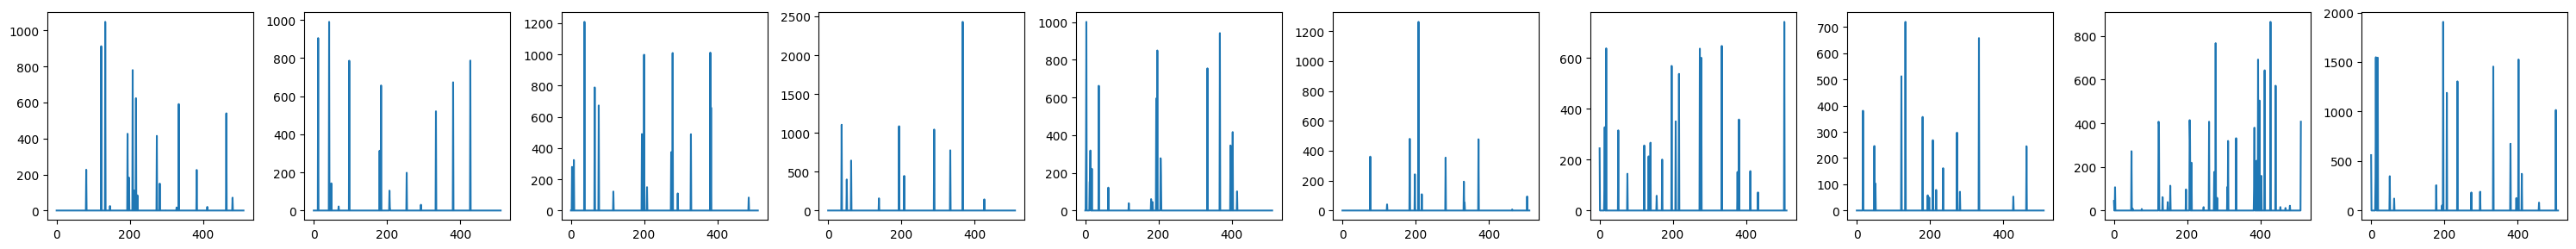

In [73]:
for ax, i in subplots(len(image_stack)):
    x = image_stack[i, 0].detach().cpu().numpy()
    a, b = np.percentile(x, (0, 99))
    plt.imshow(x, vmin=a, vmax=b)
    # plt.imshow(x)
    plt.axis("off")
    if i == 0:
        plt.xlabel("input channel 6")

for ax, i in subplots(len(preds)):
    x = brigh_spots[i, 0].detach().cpu().numpy()
    a, b = np.percentile(x, (0, 99))
    plt.imshow(x, vmin=a, vmax=b)
    # plt.imshow(x)
    plt.axis("off")
    if i == 0:
        plt.xlabel("target")

for ax, i in subplots(len(preds)):
    x = preds[i, 0].detach().cpu().numpy()
    a, b = np.percentile(x, (1, 99))
    plt.imshow(x, vmin=a, vmax=b)
    # plt.imshow(x)
    plt.axis("off")
    if i == 0:
        plt.xlabel("prediction")

for ax, i in subplots(len(embs)):
    x = embs[i].detach().cpu().numpy()
    plt.plot(x)

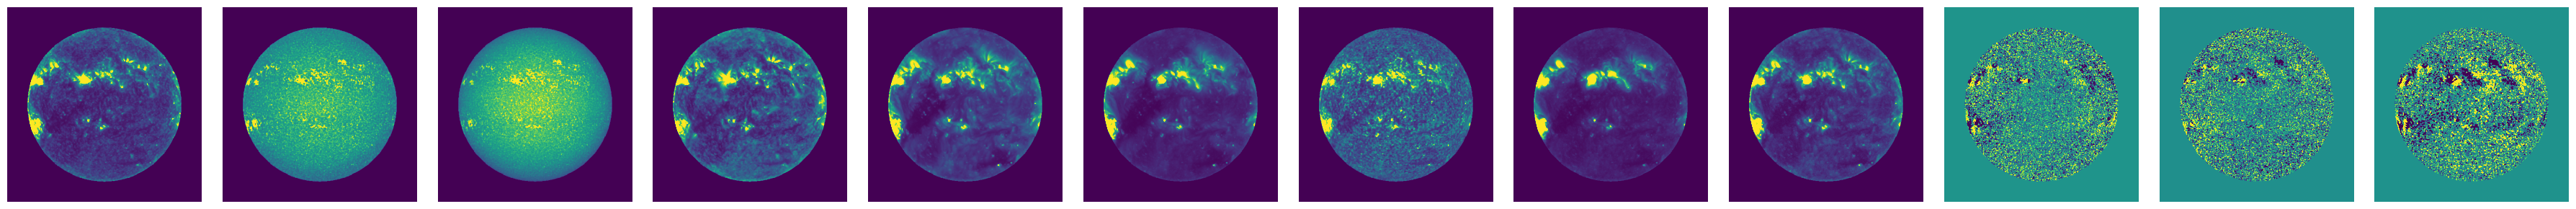

In [75]:
idx = 9

img = image_stack[idx]
for ax, i in subplots(len(img), n_cols=12):
    x = img[i].detach().cpu().numpy()
    a, b = np.percentile(x, (0, 99) if i < 9 else (5, 95))
    plt.imshow(x, vmin=a, vmax=b)
    plt.axis("off")

In [76]:
x = model.inc(image_stack)
x = model.down1(x)
encoder_at_layer2 = model.down2(x)
encoder_at_lastlayer = model.forward_encode(image_stack)

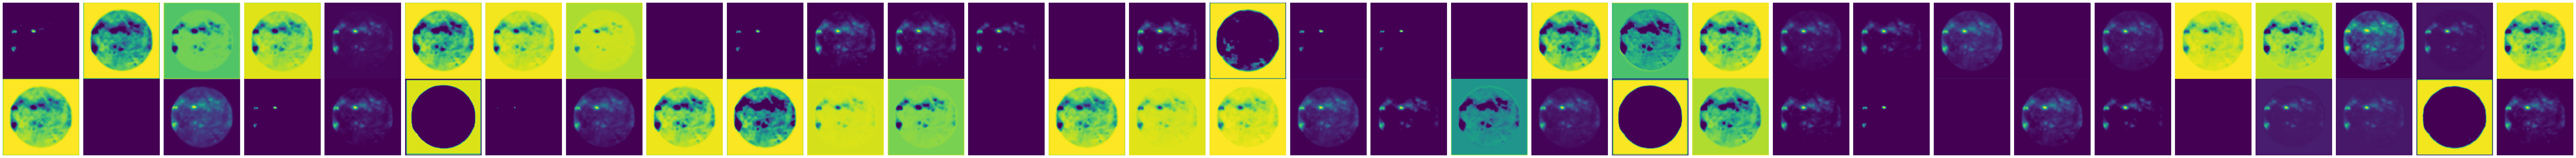

In [80]:
x = encoder_at_layer2
for ax, i in subplots(x.shape[1], n_cols=32):
    plt.imshow(x[idx, i].cpu().detach().numpy())
    plt.axis("off")

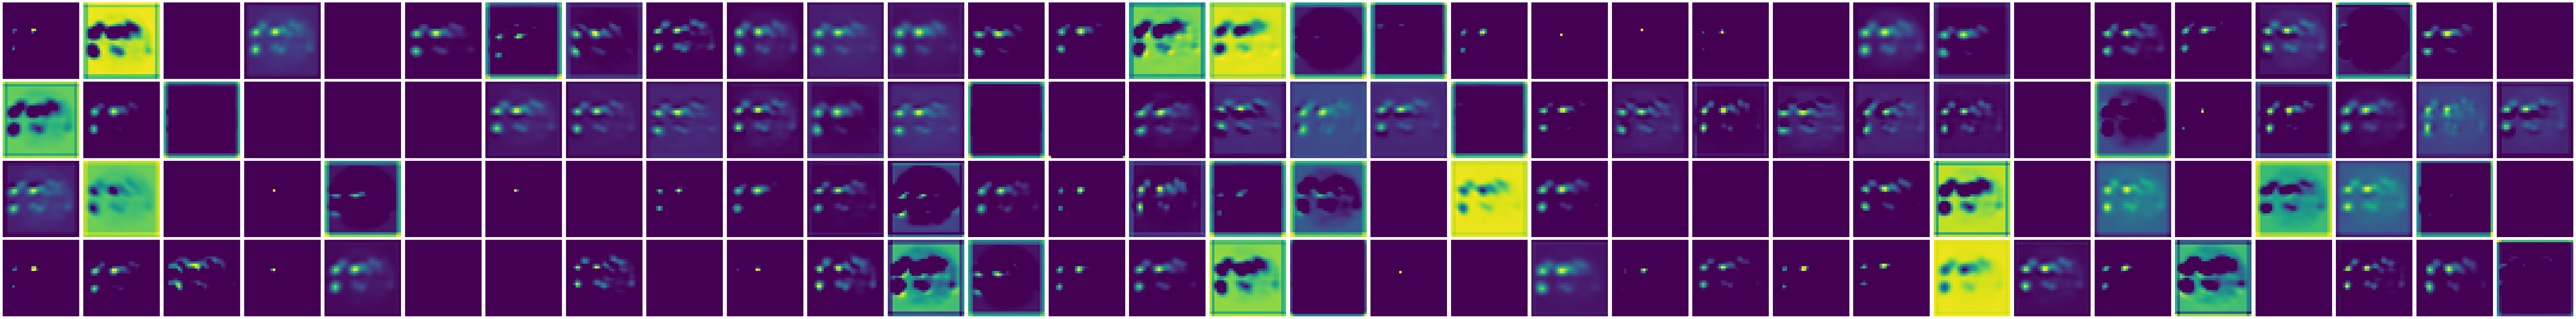

In [81]:
x = encoder_at_lastlayer
for ax, i in subplots(x.shape[1], n_cols=32):
    plt.imshow(x[idx, i].cpu().detach().numpy())
    plt.axis("off")

In [45]:
self = model
x = self.forward_encode(image_stack)
if self.use_embeddings_block:
    x = self.forward_to_embeddings(x)
    x = self.forward_from_embeddings(x)
x.shape

torch.Size([12, 128, 32, 32])

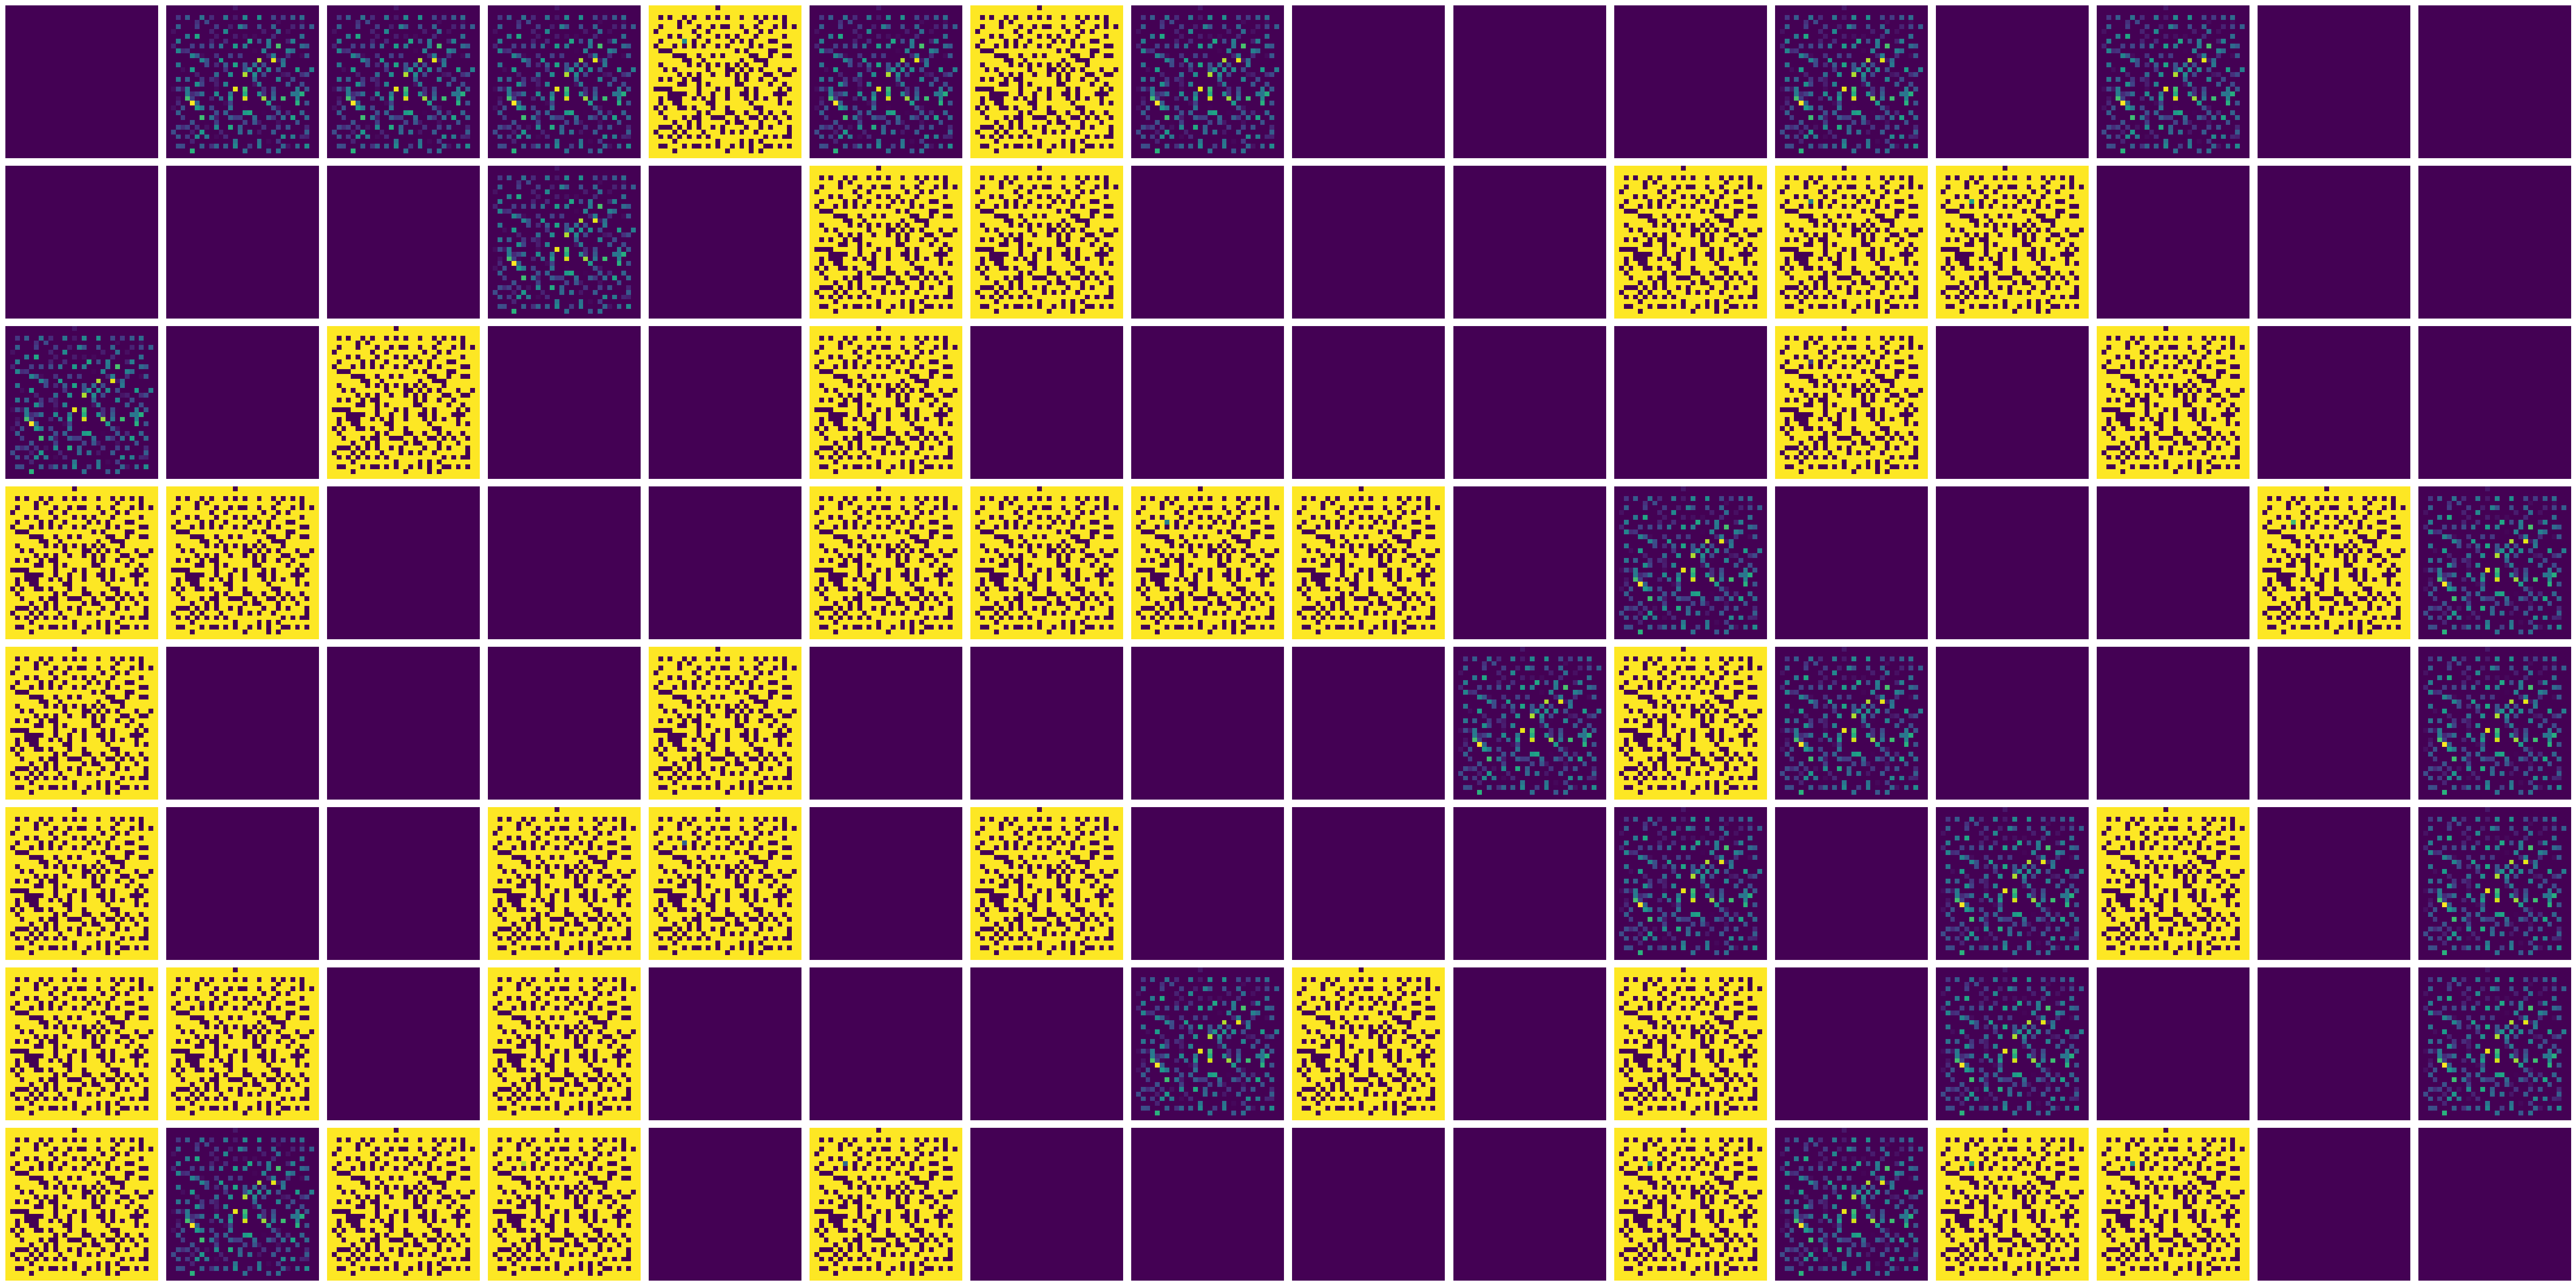

In [46]:
for ax, i in subplots(x.shape[1], n_cols=16):
    plt.imshow(x[idx, i].cpu().detach().numpy())
    plt.axis("off")

In [54]:
sum([np.prod(p.shape) for p in model.encoder_layers.parameters()])

590720

In [56]:
sum([np.prod(p.shape) for p in model.decoder_layers.parameters()])

191793

In [57]:
sum([np.prod(p.shape) for p in model.embeddings_layers.parameters()])

788865